In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.colors import BoundaryNorm
from numpy.typing import NDArray
from osgeo import gdal, ogr, osr
from pyproj import Transformer
from rasterio.windows import from_bounds
from shapely import Point, box
from tqdm import tqdm

In [4]:
# Notebook variables
INPUT_RASTER_DATES = "../data/sufosat/mosaics_tropisco_warnings_france_date.tif"
INPUT_RASTER_PROBAS = "../data/sufosat/mosaics_tropisco_warnings_france_prob.tif"
OUTPUT_LAYER = "../data/sufosat/sufosat_clear_cuts_2024.fgb"
SUFOSAT_START_DATE = pd.Timestamp(year=2014, month=4, day=3)
START_DATE_CUTOFF = pd.Timestamp(year=2024, month=1, day=1)
MAX_METERS_BETWEEN_CLEAR_CUTS = 50
MAX_DAYS_BETWEEN_CLEAR_CUTS = 7 * 4
MAGIC_NUMBER = 0.42

## Explore SUFOSAT data

SUFOSAT: https://ee-sufosatclearcuts.projects.earthengine.app/view/sufosat-clearcuts-fr comes with two raster files that cover the entire France.
One contains the clear cut date (since 2014) and one that contains the clear cut probability.


In [1]:
# Download Sufosat data
!mkdir -p ../data/sufosat
!wget https://zenodo.org/records/13685177/files/mosaics_tropisco_warnings_france_date.tif?download=1 -O ../data/sufosat/mosaics_tropisco_warnings_france_date.tif
!wget https://zenodo.org/records/13685177/files/mosaics_tropisco_warnings_france_prob.tif?download=1 -O ../data/sufosat/mosaics_tropisco_warnings_france_prob.tif

--2025-02-24 15:09:30--  https://zenodo.org/records/13685177/files/mosaics_tropisco_warnings_france_date.tif?download=1
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:24::100:f6, 2001:1458:d00:61::100:2f3, 2001:1458:d00:25::100:372, ...
Connecting to zenodo.org (zenodo.org)|2001:1458:d00:24::100:f6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96946219 (92M) [image/tiff]
Saving to: ‘../data/sufosat/mosaics_tropisco_warnings_france_date.tif’

../data/sufosat/mos 100%[===================>]  92,46M  36,4MB/s    in 2,5s    

2025-02-24 15:09:32 (36,4 MB/s) - ‘../data/sufosat/mosaics_tropisco_warnings_france_date.tif’ saved [96946219/96946219]

--2025-02-24 15:09:33--  https://zenodo.org/records/13685177/files/mosaics_tropisco_warnings_france_prob.tif?download=1
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:25::100:372, 2001:1458:d00:61::100:2f3, 2001:1458:d00:24::100:f6, ...
Connecting to zenodo.org (zenodo.org)|2001:1458:d00:25::100:372|:443... connect

### Plot an example


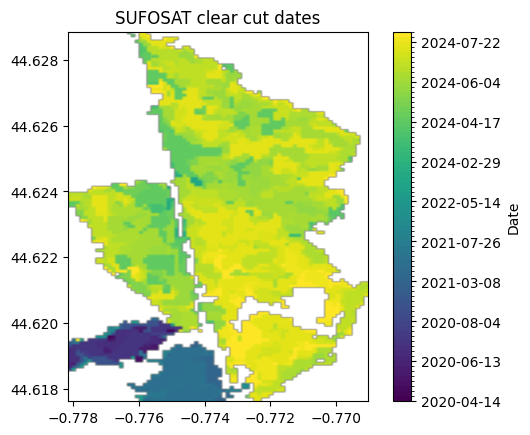

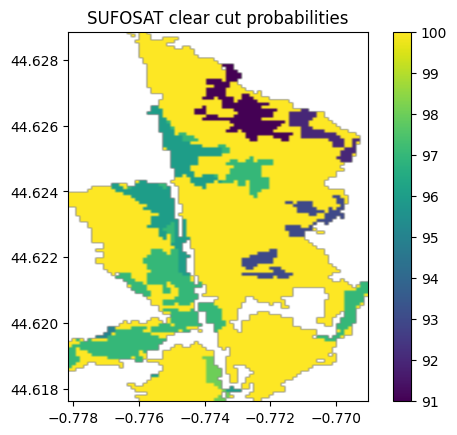

In [30]:
def load_raster_subset(
    raster_path: str,
    minx: float,
    maxx: float,
    miny: float,
    maxy: float,
    min_date: pd.Timestamp | None = None,
) -> tuple[NDArray[np.floating], tuple[float]]:
    # Load a subset of a raster file based on given bounds.
    with rasterio.open(raster_path) as src:
        window = from_bounds(
            left=minx, bottom=miny, right=maxx, top=maxy, transform=src.transform
        )
        data = src.read(1, window=window)

        # Get updated transform for the subset
        transform = src.window_transform(window)

    # Remove dates prior to min_date
    if min_date:
        data[data < (min_date - SUFOSAT_START_DATE).days] = src.nodata

    # Prepare data for plotting
    data = data.astype(float)
    data[data == 0] = np.nan

    # Compute extent for imshow
    left, top = transform * (0, 0)  # Upper-left corner in world coordinates
    right, bottom = transform * (data.shape[1], data.shape[0])  # Lower-right corner
    extent = (left, right, bottom, top)

    return data, extent


def plot_raster_dates(
    data: NDArray[np.floating],
    extent: tuple[float],
    clear_cut: gpd.GeoDataFrame | None = None,
) -> None:
    # Set up color mapping
    categories_thresholds = np.unique(data[~np.isnan(data)])
    if len(categories_thresholds) < 2:
        categories_thresholds = np.array(
            [categories_thresholds[0] - 1, categories_thresholds[0] + 1]
        )
    # Use the recommended way to get colormap
    cmap = plt.colormaps["viridis"].resampled(len(categories_thresholds))
    norm = BoundaryNorm(
        boundaries=categories_thresholds, ncolors=len(categories_thresholds)
    )

    # Create plot
    fig, ax = plt.subplots()
    img = ax.imshow(data, cmap=cmap, norm=norm, extent=extent)

    # Configure colorbar with dates
    cbar = plt.colorbar(img)
    tick_values = cbar.get_ticks()
    tick_labels = [
        (SUFOSAT_START_DATE + pd.Timedelta(days=int(tick))).strftime("%Y-%m-%d")
        for tick in tick_values
    ]

    cbar.set_ticks(tick_values)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label("Date")

    # Plot the clear cut polygon
    if clear_cut is not None:
        clear_cut.to_crs(epsg=4326).plot(
            ax=ax, facecolor="none", edgecolor="red", linewidth=1
        )

    plt.title("SUFOSAT clear cut dates")
    plt.show()


def plot_raster_probabilities(data: NDArray[np.floating], extent: tuple[float]) -> None:
    plt.imshow(data, extent=extent)
    plt.colorbar()
    plt.title("SUFOSAT clear cut probabilities")
    plt.show()


def plot_example(gdf_group: gpd.GeoDataFrame, long: float, lat: float) -> None:
    # Convert longitude and latitude from WGS84 (EPSG:4326) to Lambert 93 (EPSG:2154)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154", always_xy=True)
    point = Point(transformer.transform(long, lat))
    clear_cut = gdf_group[gdf_group.contains(point)]
    print("ID =", clear_cut.index[0])

    # See for yourself with Sentinel 2 images
    print(f"https://browser.dataspace.copernicus.eu/?zoom=17&lat={lat}&lng={long}")
    print(f"https://www.google.com/maps?q={lat},{long}")

    # Clear cut area
    print(f"{clear_cut.area.iloc[0] / 10000:.2f} hectares clear cut")

    # Plot the raster data (maybe we could overlay both in one plot)
    minx, miny, maxx, maxy = (
        clear_cut.to_crs(epsg=4326).geometry.bounds.iloc[0].tolist()
    )
    data, extent = load_raster_subset(
        raster_path=INPUT_RASTER_DATES,
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        min_date=START_DATE_CUTOFF,
    )
    plot_raster_dates(data, extent, clear_cut)


long, lat = -0.77319, 44.62325
size = 0.006
minx, maxx, miny, maxy = (
    -0.7781456631782495,
    -0.7690339007836599,
    44.61761959544384,
    44.62885826228384,
)
plot_raster_dates(
    *load_raster_subset(
        raster_path=INPUT_RASTER_DATES,
        minx=minx,
        maxx=maxx,
        miny=miny,
        maxy=maxy,
    )
)
plot_raster_probabilities(
    *load_raster_subset(
        raster_path=INPUT_RASTER_PROBAS,
        minx=minx,
        maxx=maxx,
        miny=miny,
        maxy=maxy,
    )
)

### Explore the clear cut probabilties file

Let's see what is the distribution of the clear cut probabilities


In [6]:
def explore_probabilities() -> None:
    """
    This function describes the SUFOSAT clear cuts probabilities
    """
    probas = []
    with rasterio.open(INPUT_RASTER_PROBAS) as src:
        # Read the data as a generator (window-by-window) to avoid out Of memory issues
        # since the total grid contains billions of points
        for _, window in tqdm(
            src.block_windows(),
            total=src.width
            * src.height
            // (src.block_shapes[0][0] * src.block_shapes[0][1]),
        ):
            # Read the block data for the first and only band
            data = src.read(1, window=window)

            # Ignore the block if it contains no data
            if np.all(data == src.nodata):
                continue

            data_probas = data.flatten()
            data_probas = data_probas[data_probas != 0]
            probas.append(data_probas)

    # Show probabilities statistics
    display(pd.Series(np.concatenate(probas)).describe().astype(int))


explore_probabilities()

  0%|          | 0/15370 [00:00<?, ?it/s]

15458it [00:54, 281.36it/s]                           


count    40077177
mean           97
std             2
min            89
25%            96
50%            99
75%           100
max           100
dtype: int64

The minimum probability from appears to be 89%.
That's surprisingly high.
I guess we can safely ignore this probability file.


## Cluster clear cuts by space and time

Clear cuts that are within X meters and Y days of each other should be grouped as a single event.

<p style="color: red">
⚠️ The current clustering algorithm isn't ideal (I vectorize and then perform a spatial join). It doesn't scale very well... To run this in reasonable time, I run it only on the clear cuts after 2024. In my opinion, it would be better to have a custom algorithm, like flood filling or union-find, that operates directly on the pixels. However, I haven't been able to make one work / didn't have the time to implement one myself. If anyone is interested, feel free to give it a try! ⚠️
</p>


### Vectorize SUFOSAT raster

We convert the raster data to polygons to be able to perform spatial joins.


In [7]:
def polygonize_raster(input_raster: str, output_shapefile: str, fieldname: str):
    """
    Polygonize a raster to a shapefile using 8-connectivity
    """

    # Register GDAL drivers
    gdal.AllRegister()

    # Open source file
    src_ds = gdal.Open(input_raster)
    if src_ds is None:
        raise ValueError(f"Unable to open {input_raster}")

    # Get the first band
    srcband = src_ds.GetRasterBand(1)
    maskband = srcband.GetMaskBand()

    # Create output file
    drv = ogr.GetDriverByName("FlatGeobuf")
    dst_ds = drv.CreateDataSource(output_shapefile)

    # Create layer
    srs = None
    if src_ds.GetProjectionRef() != "":
        srs = osr.SpatialReference()
        srs.ImportFromWkt(src_ds.GetProjectionRef())

    dst_layer = dst_ds.CreateLayer("out", geom_type=ogr.wkbPolygon, srs=srs)

    # Add field
    fd = ogr.FieldDefn(fieldname, ogr.OFTInteger)
    dst_layer.CreateField(fd)

    # Polygonize with 8-connectivity
    options = ["8CONNECTED=8"]
    gdal.Polygonize(srcband, maskband, dst_layer, 0, options)


# This takes 5-10 minutes
polygonize_raster(
    input_raster=INPUT_RASTER_DATES,
    output_shapefile="../data/sufosat/sufosat.fgb",
    fieldname="days",
)

### Vectorized SUFOSAT plot


In [32]:
gdf: gpd.GeoDataFrame = gpd.read_file("../data/sufosat/sufosat.fgb")
gdf["date"] = SUFOSAT_START_DATE + pd.to_timedelta(gdf["days"], unit="D")
gdf

,days,geometry,date
0,3725,"POLYGON ((9.43926 41.1001, 9.43926 41.10001, 9...",2024-06-14
1,3683,"POLYGON ((9.43902 41.1001, 9.43902 41.10001, 9...",2024-05-03
2,3671,"POLYGON ((9.43914 41.1001, 9.43914 41.10001, 9...",2024-04-21
3,3749,"POLYGON ((9.4395 41.10001, 9.4395 41.09992, 9....",2024-07-08
4,3695,"POLYGON ((9.43938 41.09983, 9.43938 41.09964, ...",2024-05-15
...,...,...,...
5920292,3684,"POLYGON ((-1.65395 43.3665, -1.65395 43.36641,...",2024-05-04
5920293,3732,"POLYGON ((-1.65347 43.36632, -1.65347 43.36623...",2024-06-21
5920294,3672,"POLYGON ((-1.65407 43.36641, -1.65407 43.36632...",2024-04-22
5920295,3726,"POLYGON ((-1.65419 43.36632, -1.65419 43.36623...",2024-06-15


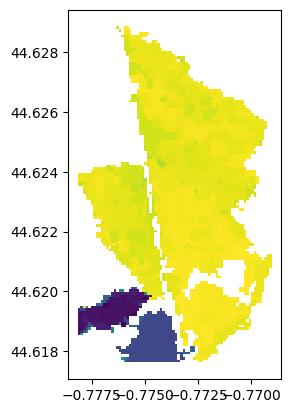

In [33]:
gdf.clip(box(minx, miny, maxx, maxy)).plot(column="days")
gdf = gdf.drop(columns="days")

### Geopandas spatial join


The number of polygons is huge and it will take some time to cluster. Therefore, for the moment, we only process the recent data, since 2024.


In [6]:
gdf: gpd.GeoDataFrame = gdf[gdf["date"] >= START_DATE_CUTOFF]
gdf

,geometry,date
0,"POLYGON ((9.43926 41.1001, 9.43926 41.10001, 9...",2024-06-14
1,"POLYGON ((9.43902 41.1001, 9.43902 41.10001, 9...",2024-05-03
2,"POLYGON ((9.43914 41.1001, 9.43914 41.10001, 9...",2024-04-21
3,"POLYGON ((9.4395 41.10001, 9.4395 41.09992, 9....",2024-07-08
4,"POLYGON ((9.43938 41.09983, 9.43938 41.09964, ...",2024-05-15
...,...,...
5920292,"POLYGON ((-1.65395 43.3665, -1.65395 43.36641,...",2024-05-04
5920293,"POLYGON ((-1.65347 43.36632, -1.65347 43.36623...",2024-06-21
5920294,"POLYGON ((-1.65407 43.36641, -1.65407 43.36632...",2024-04-22
5920295,"POLYGON ((-1.65419 43.36632, -1.65419 43.36623...",2024-06-15


We want to group the clear-cuts that are less than 50 meters apart.
To achieve this, we will perform a spatial join.
Before joining, we will buffer each polygon by 25 meters.


In [7]:
# Reproject into a coordinate system with meters as units (Lambert-93)
gdf = gdf.to_crs(epsg=2154)
# Buffer each clear cut by half the max distance between clear cuts
gdf["buffered"] = gdf.geometry.buffer(MAX_METERS_BETWEEN_CLEAR_CUTS / 2)
gdf

,geometry,date,buffered
0,"POLYGON ((1242175.431 6021839.56, 1242176.254 ...",2024-06-14,"POLYGON ((1242166.208 6021806.607, 1242164.104..."
1,"POLYGON ((1242155.287 6021837.914, 1242156.109...",2024-05-03,"POLYGON ((1242142.897 6021806.66, 1242141.876 ..."
2,"POLYGON ((1242165.359 6021838.737, 1242166.182...",2024-04-21,"POLYGON ((1242163.322 6021863.654, 1242173.395..."
3,"POLYGON ((1242196.399 6021831.141, 1242197.221...",2024-07-08,"POLYGON ((1242194.362 6021856.058, 1242204.434..."
4,"POLYGON ((1242187.972 6021810.186, 1242189.617...",2024-05-15,"POLYGON ((1242185.935 6021835.103, 1242206.08 ..."
...,...,...,...
5920292,"POLYGON ((322793.056 6263048.926, 322792.463 6...",2024-05-04,"POLYGON ((322778.793 6263017.967, 322777.373 6..."
5920293,"POLYGON ((322830.694 6263026.521, 322830.1 626...",2024-06-21,"POLYGON ((322832.166 6263051.477, 322841.872 6..."
5920294,"POLYGON ((322782.757 6263039.441, 322782.163 6...",2024-04-22,"POLYGON ((322784.229 6263064.398, 322803.641 6..."
5920295,"POLYGON ((322772.457 6263029.957, 322771.864 6...",2024-06-15,"POLYGON ((322773.93 6263054.913, 322783.636 62..."


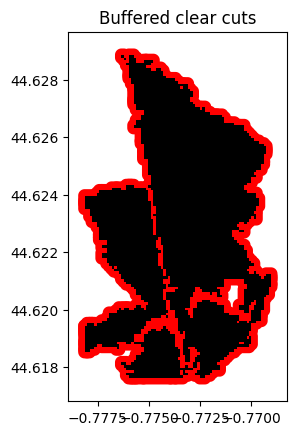

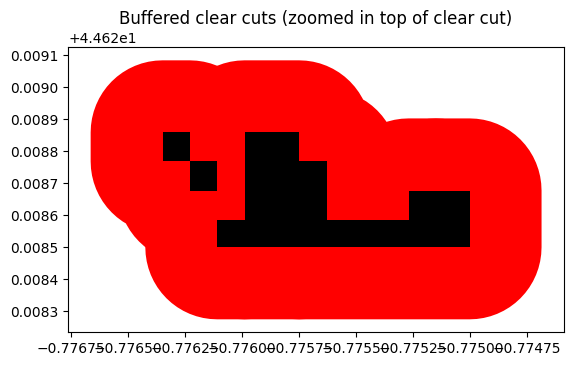

In [40]:
fig, ax = plt.subplots()
gdf.clip(box(minx, miny, maxx, maxy)).to_crs(epsg=2154).geometry.buffer(
    MAX_METERS_BETWEEN_CLEAR_CUTS / 2
).to_crs(epsg=4326).plot(ax=ax, color="red", alpha=1)
gdf.clip(box(minx, miny, maxx, maxy)).plot(ax=ax, color="black", alpha=1)
ax.set_title("Buffered clear cuts")
plt.show()

fig, ax = plt.subplots()
gdf.clip(box(minx, 44.6285, -0.7750, maxy)).to_crs(epsg=2154).geometry.buffer(
    MAX_METERS_BETWEEN_CLEAR_CUTS / 2
).to_crs(epsg=4326).plot(ax=ax, color="red", alpha=1)
gdf.clip(box(minx, 44.6285, -0.7750, maxy)).plot(ax=ax, color="black", alpha=1)
ax.set_title("Buffered clear cuts (zoomed in top of clear cut)")
plt.show()

Now we can join the buffered clear cuts that intersect


In [8]:
gdf_buffered = gdf.set_geometry("buffered").drop(columns="geometry")
gdf_cluster: gpd.GeoDataFrame = gdf_buffered.sjoin(
    gdf_buffered, predicate="intersects"
).drop(columns="buffered")
gdf_cluster: gpd.GeoDataFrame = gdf_cluster.reset_index().rename(
    columns={"index": "index_left"}
)
gdf_cluster

,index_left,date_left,index_right,date_right
0,0,2024-06-14,8,2024-05-27
1,0,2024-06-14,7,2024-06-02
2,0,2024-06-14,9,2024-06-08
3,0,2024-06-14,6,2024-06-14
4,0,2024-06-14,4,2024-05-15
...,...,...,...,...
4919548,5920296,2024-07-03,5920294,2024-04-22
4919549,5920296,2024-07-03,5920292,2024-05-04
4919550,5920296,2024-07-03,5920291,2024-05-10
4919551,5920296,2024-07-03,5920289,2024-06-21


In [9]:
# Ignore clear cuts that intersect with themselves
gdf_cluster = gdf_cluster[gdf_cluster["index_left"] != gdf_cluster["index_right"]]
gdf_cluster

,index_left,date_left,index_right,date_right
0,0,2024-06-14,8,2024-05-27
1,0,2024-06-14,7,2024-06-02
2,0,2024-06-14,9,2024-06-08
3,0,2024-06-14,6,2024-06-14
4,0,2024-06-14,4,2024-05-15
...,...,...,...,...
4919548,5920296,2024-07-03,5920294,2024-04-22
4919549,5920296,2024-07-03,5920292,2024-05-04
4919550,5920296,2024-07-03,5920291,2024-05-10
4919551,5920296,2024-07-03,5920289,2024-06-21


In [10]:
# Remove duplicates (left-right and right-left pairs)
gdf_cluster = gdf_cluster[gdf_cluster["index_left"] < gdf_cluster["index_right"]]
gdf_cluster

,index_left,date_left,index_right,date_right
0,0,2024-06-14,8,2024-05-27
1,0,2024-06-14,7,2024-06-02
2,0,2024-06-14,9,2024-06-08
3,0,2024-06-14,6,2024-06-14
4,0,2024-06-14,4,2024-05-15
...,...,...,...,...
4919520,5920293,2024-06-21,5920295,2024-06-15
4919521,5920293,2024-06-21,5920294,2024-04-22
4919526,5920294,2024-04-22,5920296,2024-07-03
4919528,5920294,2024-04-22,5920295,2024-06-15


In [11]:
# Remove pairs if the date difference is too big
gdf_cluster = gdf_cluster[
    (gdf_cluster["date_left"] - gdf_cluster["date_right"]).dt.days.abs()
    <= MAX_DAYS_BETWEEN_CLEAR_CUTS
]
gdf_cluster

,index_left,date_left,index_right,date_right
0,0,2024-06-14,8,2024-05-27
1,0,2024-06-14,7,2024-06-02
2,0,2024-06-14,9,2024-06-08
3,0,2024-06-14,6,2024-06-14
5,0,2024-06-14,5,2024-05-21
...,...,...,...,...
4919505,5920291,2024-05-10,5920292,2024-05-04
4919513,5920292,2024-05-04,5920294,2024-04-22
4919518,5920293,2024-06-21,5920296,2024-07-03
4919520,5920293,2024-06-21,5920295,2024-06-15


Now that we've identified clear-cut pairs, we need to group the connected clear cuts.
For example, if we have four clear cuts A, B, C, and D and the identified pairs are (A, B) and (B, D), we will assign:

- Group 1: A, B, D
- Group 2: C


In [14]:
# Code from https://github.com/scipy/scipy/blob/v1.15.2/scipy/_lib/_disjoint_set.py#L0-L1
# We could import it from scipy but that might be an unnecessary dependency for this simple data structure
class DisjointSet:
    """Disjoint set data structure for incremental connectivity queries.

    .. versionadded:: 1.6.0

    Attributes
    ----------
    n_subsets : int
        The number of subsets.

    Methods
    -------
    add
    merge
    connected
    subset
    subset_size
    subsets
    __getitem__

    Notes
    -----
    This class implements the disjoint set [1]_, also known as the *union-find*
    or *merge-find* data structure. The *find* operation (implemented in
    `__getitem__`) implements the *path halving* variant. The *merge* method
    implements the *merge by size* variant.

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Disjoint-set_data_structure

    Examples
    --------
    >>> from scipy.cluster.hierarchy import DisjointSet

    Initialize a disjoint set:

    >>> disjoint_set = DisjointSet([1, 2, 3, 'a', 'b'])

    Merge some subsets:

    >>> disjoint_set.merge(1, 2)
    True
    >>> disjoint_set.merge(3, 'a')
    True
    >>> disjoint_set.merge('a', 'b')
    True
    >>> disjoint_set.merge('b', 'b')
    False

    Find root elements:

    >>> disjoint_set[2]
    1
    >>> disjoint_set['b']
    3

    Test connectivity:

    >>> disjoint_set.connected(1, 2)
    True
    >>> disjoint_set.connected(1, 'b')
    False

    List elements in disjoint set:

    >>> list(disjoint_set)
    [1, 2, 3, 'a', 'b']

    Get the subset containing 'a':

    >>> disjoint_set.subset('a')
    {'a', 3, 'b'}

    Get the size of the subset containing 'a' (without actually instantiating
    the subset):

    >>> disjoint_set.subset_size('a')
    3

    Get all subsets in the disjoint set:

    >>> disjoint_set.subsets()
    [{1, 2}, {'a', 3, 'b'}]
    """

    def __init__(self, elements=None):
        self.n_subsets = 0
        self._sizes = {}
        self._parents = {}
        # _nbrs is a circular linked list which links connected elements.
        self._nbrs = {}
        # _indices tracks the element insertion order in `__iter__`.
        self._indices = {}
        if elements is not None:
            for x in elements:
                self.add(x)

    def __iter__(self):
        """Returns an iterator of the elements in the disjoint set.

        Elements are ordered by insertion order.
        """
        return iter(self._indices)

    def __len__(self):
        return len(self._indices)

    def __contains__(self, x):
        return x in self._indices

    def __getitem__(self, x):
        """Find the root element of `x`.

        Parameters
        ----------
        x : hashable object
            Input element.

        Returns
        -------
        root : hashable object
            Root element of `x`.
        """
        if x not in self._indices:
            raise KeyError(x)

        # find by "path halving"
        parents = self._parents
        while self._indices[x] != self._indices[parents[x]]:
            parents[x] = parents[parents[x]]
            x = parents[x]
        return x

    def add(self, x):
        """Add element `x` to disjoint set"""
        if x in self._indices:
            return

        self._sizes[x] = 1
        self._parents[x] = x
        self._nbrs[x] = x
        self._indices[x] = len(self._indices)
        self.n_subsets += 1

    def merge(self, x, y):
        """Merge the subsets of `x` and `y`.

        The smaller subset (the child) is merged into the larger subset (the
        parent). If the subsets are of equal size, the root element which was
        first inserted into the disjoint set is selected as the parent.

        Parameters
        ----------
        x, y : hashable object
            Elements to merge.

        Returns
        -------
        merged : bool
            True if `x` and `y` were in disjoint sets, False otherwise.
        """
        xr = self[x]
        yr = self[y]
        if self._indices[xr] == self._indices[yr]:
            return False

        sizes = self._sizes
        if (sizes[xr], self._indices[yr]) < (sizes[yr], self._indices[xr]):
            xr, yr = yr, xr
        self._parents[yr] = xr
        self._sizes[xr] += self._sizes[yr]
        self._nbrs[xr], self._nbrs[yr] = self._nbrs[yr], self._nbrs[xr]
        self.n_subsets -= 1
        return True

    def connected(self, x, y):
        """Test whether `x` and `y` are in the same subset.

        Parameters
        ----------
        x, y : hashable object
            Elements to test.

        Returns
        -------
        result : bool
            True if `x` and `y` are in the same set, False otherwise.
        """
        return self._indices[self[x]] == self._indices[self[y]]

    def subset(self, x):
        """Get the subset containing `x`.

        Parameters
        ----------
        x : hashable object
            Input element.

        Returns
        -------
        result : set
            Subset containing `x`.
        """
        if x not in self._indices:
            raise KeyError(x)

        result = [x]
        nxt = self._nbrs[x]
        while self._indices[nxt] != self._indices[x]:
            result.append(nxt)
            nxt = self._nbrs[nxt]
        return set(result)

    def subset_size(self, x):
        """Get the size of the subset containing `x`.

        Note that this method is faster than ``len(self.subset(x))`` because
        the size is directly read off an internal field, without the need to
        instantiate the full subset.

        Parameters
        ----------
        x : hashable object
            Input element.

        Returns
        -------
        result : int
            Size of the subset containing `x`.
        """
        return self._sizes[self[x]]

    def subsets(self):
        """Get all the subsets in the disjoint set.

        Returns
        -------
        result : list
            Subsets in the disjoint set.
        """
        result = []
        visited = set()
        for x in self:
            if x not in visited:
                xset = self.subset(x)
                visited.update(xset)
                result.append(xset)
        return result

In [15]:
# Start with each clear cut have its own group (i.e., a set here)
clear_cuts_disjoint_set = DisjointSet(gdf.index.tolist())

In [16]:
# Then we group the clear cuts that belong together one pair at a time
for index_left, index_right in gdf_cluster[["index_left", "index_right"]].itertuples(
    index=False
):
    clear_cuts_disjoint_set.merge(index_left, index_right)

In [17]:
# Now we can assign the clear cut group id to each polygon
subsets = clear_cuts_disjoint_set.subsets()
for i, subset in tqdm(enumerate(subsets), total=len(subsets)):
    gdf.loc[list(subset), "clear_cut_group"] = i
gdf = gdf.drop(columns="buffered")
gdf["clear_cut_group"] = gdf["clear_cut_group"].astype(int)
gdf

100%|██████████| 51466/51466 [00:14<00:00, 3534.07it/s]


,geometry,date,clear_cut_group
0,"POLYGON ((1242175.431 6021839.56, 1242176.254 ...",2024-06-14,0
1,"POLYGON ((1242155.287 6021837.914, 1242156.109...",2024-05-03,0
2,"POLYGON ((1242165.359 6021838.737, 1242166.182...",2024-04-21,0
3,"POLYGON ((1242196.399 6021831.141, 1242197.221...",2024-07-08,0
4,"POLYGON ((1242187.972 6021810.186, 1242189.617...",2024-05-15,0
...,...,...,...
5920292,"POLYGON ((322793.056 6263048.926, 322792.463 6...",2024-05-04,51465
5920293,"POLYGON ((322830.694 6263026.521, 322830.1 626...",2024-06-21,51464
5920294,"POLYGON ((322782.757 6263039.441, 322782.163 6...",2024-04-22,51465
5920295,"POLYGON ((322772.457 6263029.957, 322771.864 6...",2024-06-15,51464


### Union all the polygons


In [18]:
# Finally, for each clear cut group, we take the union of geometries and
# we report the min and max dates, as well as the number of aggregated clear cuts
gdf_group = gdf.dissolve(by="clear_cut_group", aggfunc={"date": ["min", "max"]}).rename(
    columns={
        ("date", "min"): "date_min",
        ("date", "max"): "date_max",
    }
)
gdf_group["days_delta"] = (gdf_group["date_max"] - gdf_group["date_min"]).dt.days
gdf_group["clear_cut_group_size"] = gdf.groupby("clear_cut_group").size()
gdf_group

,geometry,date_min,date_max,days_delta,clear_cut_group_size
clear_cut_group,,,,,
0,"MULTIPOLYGON (((1242171.94 6021758.209, 124217...",2024-04-21,2024-07-08,78,12
1,"MULTIPOLYGON (((1233121.944 6028390.495, 12331...",2024-03-04,2024-04-21,48,19
2,"MULTIPOLYGON (((1233226.961 6028469.862, 12332...",2024-05-15,2024-05-27,12,2
3,"POLYGON ((1233127.958 6028441.635, 1233128.768...",2024-07-08,2024-07-08,0,1
4,"POLYGON ((1233142.069 6028392.114, 1233142.879...",2024-05-21,2024-05-21,0,1
...,...,...,...,...,...
51461,"POLYGON ((341718.585 6288042.519, 341718.019 6...",2024-01-11,2024-01-11,0,1
51462,"MULTIPOLYGON (((341880.68 6287993.044, 341861....",2024-04-04,2024-04-22,18,5
51463,"POLYGON ((341725.941 6288173.263, 341724.81 62...",2024-01-11,2024-01-11,0,1


### Fill polygons gaps left after dissolve

There are tiny gaps left after the dissolve/union all operation.


ID = 26896
https://browser.dataspace.copernicus.eu/?zoom=17&lat=48.55209&lng=-2.43573
https://www.google.com/maps?q=48.55209,-2.43573
2.01 hectares clear cut


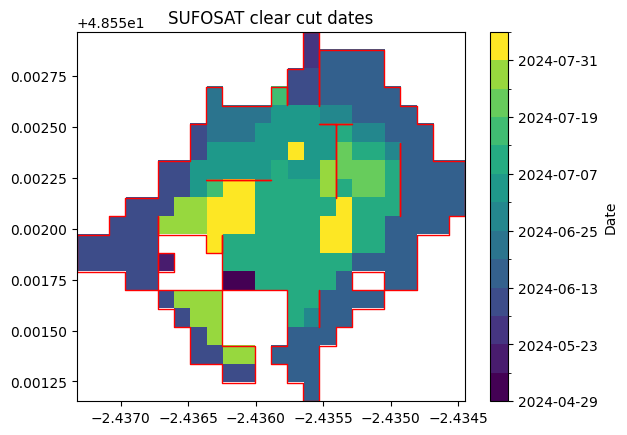

In [21]:
plot_example(gdf_group, -2.43573, 48.55209)

We're going to fill these gaps by marginally expanding the polygons by 0.0001 meters


In [22]:
gdf_group["geometry"] = gdf_group["geometry"].buffer(0.0001)

ID = 26896
https://browser.dataspace.copernicus.eu/?zoom=17&lat=48.55209&lng=-2.43573
https://www.google.com/maps?q=48.55209,-2.43573
2.01 hectares clear cut


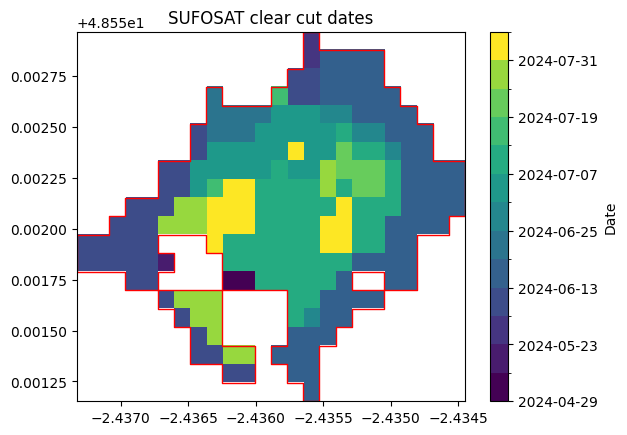

In [23]:
plot_example(gdf_group, -2.43573, 48.55209)

### Add clear cut area


In [24]:
# 1 hectare = 10,000 m²
gdf_group["area_ha"] = gdf_group.area / 10000
gdf_group

,geometry,date_min,date_max,days_delta,clear_cut_group_size,area_ha
clear_cut_group,,,,,,
0,"POLYGON ((1242170.295 6021778.341, 1242150.15 ...",2024-04-21,2024-07-08,78,12,0.500123
1,"MULTIPOLYGON (((1233121.944 6028390.495, 12331...",2024-03-04,2024-04-21,48,19,1.386440
2,"MULTIPOLYGON (((1233256.337 6028482.357, 12332...",2024-05-15,2024-05-27,12,2,0.020389
3,"POLYGON ((1233127.958 6028441.635, 1233148.082...",2024-07-08,2024-07-08,0,1,0.020389
4,"POLYGON ((1233142.069 6028392.114, 1233152.131...",2024-05-21,2024-05-21,0,1,0.010195
...,...,...,...,...,...,...
51461,"POLYGON ((341718.585 6288042.519, 341728.253 6...",2024-01-11,2024-01-11,0,1,0.009755
51462,"POLYGON ((341832.905 6288005.82, 341823.237 62...",2024-04-04,2024-04-22,18,5,0.136562
51463,"POLYGON ((341725.941 6288173.263, 341745.277 6...",2024-01-11,2024-01-11,0,1,0.039017


In [25]:
# Only keep clear cuts >= 0.5 ha
gdf_group = gdf_group[gdf_group["area_ha"] >= 0.5].copy()
gdf_group

,geometry,date_min,date_max,days_delta,clear_cut_group_size,area_ha
clear_cut_group,,,,,,
0,"POLYGON ((1242170.295 6021778.341, 1242150.15 ...",2024-04-21,2024-07-08,78,12,0.500123
1,"MULTIPOLYGON (((1233121.944 6028390.495, 12331...",2024-03-04,2024-04-21,48,19,1.386440
17,"POLYGON ((1198216.849 6067996.198, 1198216.087...",2024-06-20,2024-07-14,24,7,0.617602
20,"MULTIPOLYGON (((1163543.691 6133084.278, 11635...",2024-04-08,2024-07-25,108,51,2.102984
21,"POLYGON ((1188128.497 6151090.369, 1188128.497...",2024-05-26,2024-07-14,49,6,0.509373
...,...,...,...,...,...,...
51445,"MULTIPOLYGON (((340298.087 6286246.005, 340298...",2024-04-04,2024-06-21,78,39,3.122274
51449,"POLYGON ((340233.26 6285957.077, 340213.917 62...",2024-04-10,2024-05-10,30,10,0.829407
51450,"POLYGON ((341600.576 6285082.948, 341600.576 6...",2024-06-09,2024-08-02,54,49,3.239931


### Filter clear cuts by compactness

Due to the way we cluster clear-cuts through propagation, we may end up with very sparse clear-cut groups.
This can lead to false positives, incorrectly identifying certain areas as abusive clear-cuts.
To mitigate this, we will remove or ignore clear-cuts with overly complex shapes.


ID = 46693
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.55644&lng=-1.19369
https://www.google.com/maps?q=44.55644,-1.19369
176.35 hectares clear cut


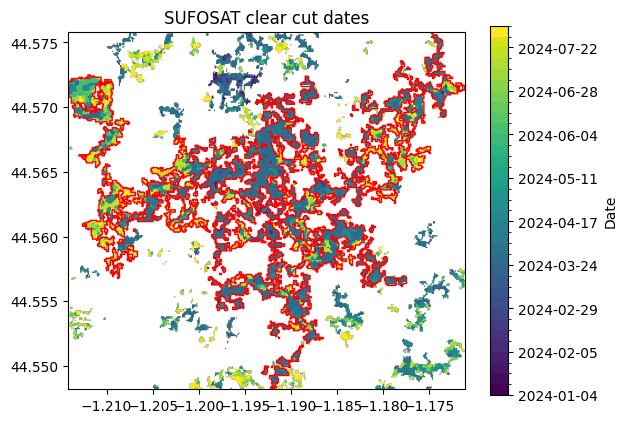

In [26]:
plot_example(gdf_group, -1.19369, 44.55644)

There are many methods we can use to estimate the complexity of a shape:

- Simple Count Method: Count the number of separate polygons in a multipolygon
- Polsby-Popper Compactness: Calculates the ratio of the area of the shape to the area of a circle with the same perimeter
- Convex / Concave Hull Score: Ratio of the area of the shape to the area of its convex/concave hull
- Perimeter-to-Area Ratio: Relationship between boundary length and filled area
- ...

In our case, we'll use a concave hull score (with a migic ratio of 0.42), but we could use a different metric, or a combination of metrics to have better results


In [27]:
# concave_hull(ratio=1) would be the same as convex_hull
# 0.42 is a magic number but it does the job!
gdf_group["concave_hull_score"] = (
    gdf_group.area / gdf_group.concave_hull(MAGIC_NUMBER).area
)
gdf_group.sort_values("concave_hull_score")

,geometry,date_min,date_max,days_delta,clear_cut_group_size,area_ha,concave_hull_score
clear_cut_group,,,,,,,
41554,"MULTIPOLYGON (((424994.657 6385679.411, 425004...",2024-07-22,2024-08-03,12,60,6.178649,0.171051
43433,"MULTIPOLYGON (((394911.405 6378946.68, 394920....",2024-05-23,2024-07-26,64,27,0.547580,0.172208
30679,"MULTIPOLYGON (((484254.298 6457224.834, 484254...",2024-06-11,2024-08-02,52,23,0.540299,0.176748
42578,"MULTIPOLYGON (((423824.507 6366199.429, 423824...",2024-03-12,2024-03-24,12,19,0.606348,0.180262
18064,"MULTIPOLYGON (((868112.748 6630519.439, 868112...",2024-04-30,2024-07-30,91,32,0.663299,0.184146
...,...,...,...,...,...,...,...
11298,"POLYGON ((939748.557 6610047.06, 939749.355 66...",2024-07-18,2024-07-31,13,3,0.517814,4.148154
33989,"POLYGON ((627694.426 6502451.763, 627694.426 6...",2024-05-30,2024-07-29,60,83,7.711215,4.361720
26164,"POLYGON ((162722.037 6772404.715, 162722.037 6...",2024-03-22,2024-03-22,0,1,1.219482,4.576289


Checking the distribution of the metric...


<Axes: ylabel='Frequency'>

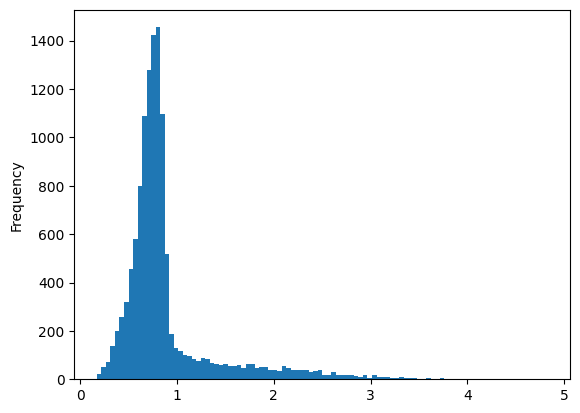

In [28]:
gdf_group["concave_hull_score"].plot.hist(bins=100)

In [29]:
gdf_group["concave_hull_score"].quantile([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1])

0.00    0.171051
0.01    0.300790
0.02    0.348711
0.03    0.381083
0.04    0.406517
0.05    0.431352
0.10    0.517368
1.00    4.833342
Name: concave_hull_score, dtype: float64

and plotting a bunch of example to get a sense of the metric...


concave_hull_score = 0.17105147845411495


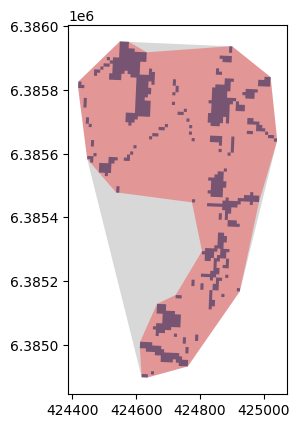

concave_hull_score = 0.4608051708748248


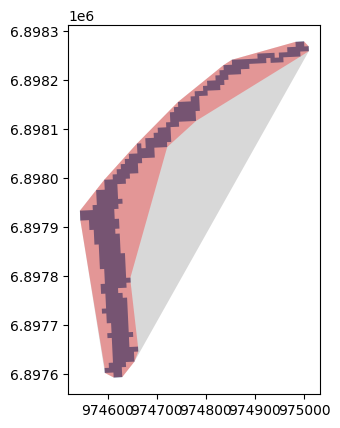

concave_hull_score = 0.5967447752191813


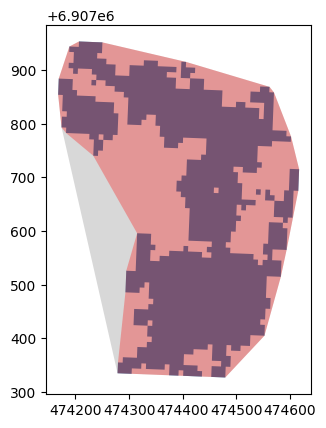

concave_hull_score = 0.2820319424924504


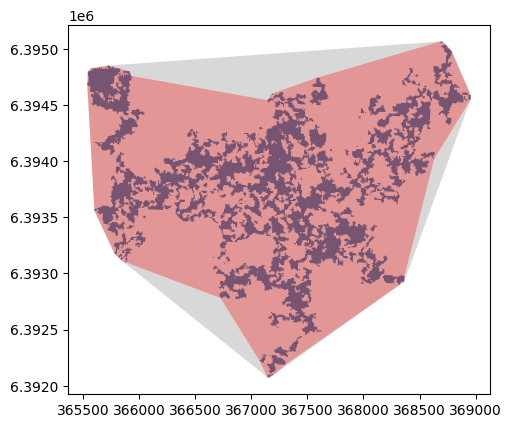

concave_hull_score = 0.3832336970890035


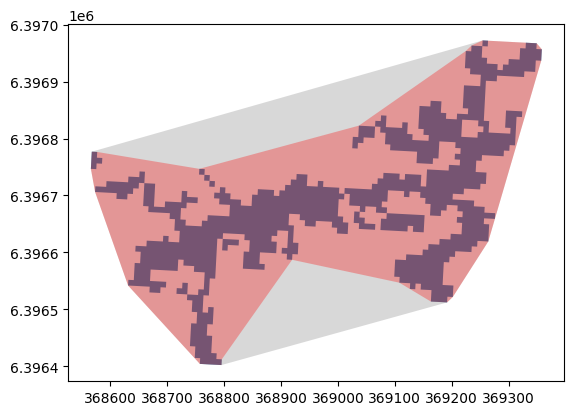

concave_hull_score = 0.8879713443889976


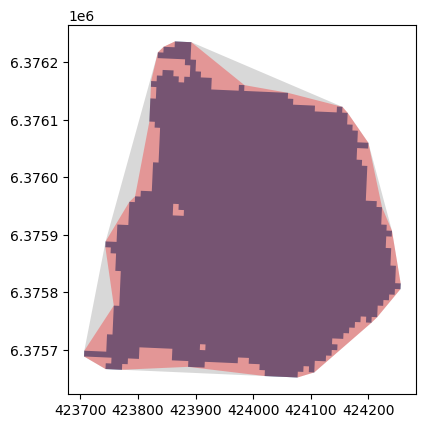

concave_hull_score = 0.4057165518112924


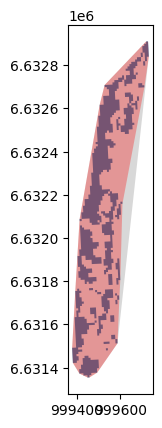

concave_hull_score = 4.361719757957248


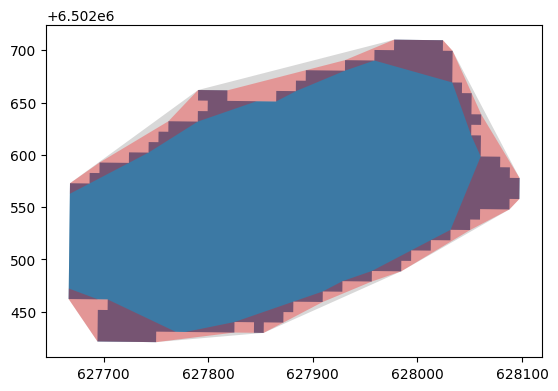

concave_hull_score = 0.3131609769478348


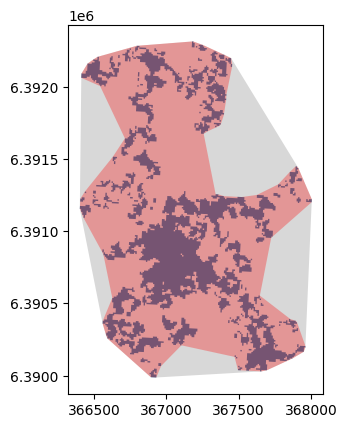

In [30]:
def plot_concave(id: int) -> None:
    fix, ax = plt.subplots()
    print("concave_hull_score =", gdf_group.loc[id, "concave_hull_score"])
    gdf_group.loc[[id]].plot(ax=ax)
    gdf_group.loc[[id]].convex_hull.plot(ax=ax, color="grey", alpha=0.3)
    gdf_group.loc[[id]].concave_hull(MAGIC_NUMBER).plot(ax=ax, color="red", alpha=0.3)
    plt.show()


plot_concave(41554)
plot_concave(13782)
plot_concave(25319)
plot_concave(46693)
plot_concave(47026)
plot_concave(42465)
plot_concave(11082)
plot_concave(33989)
plot_concave(46666)

Let's choose 0.42 as the magic threshold number.
According to the quantiles, we should exclude less than 5% of the clear cuts.


### A few examples of the ignored clear cuts

Let's plot a few examples of the clear cuts that we'll ignore because they are too complex.


concave_hull_score = 0.18414629320773457
ID = 18064
https://browser.dataspace.copernicus.eu/?zoom=17&lat=46.75246780443864&lng=5.202047867584088
https://www.google.com/maps?q=46.75246780443864,5.202047867584088
0.66 hectares clear cut


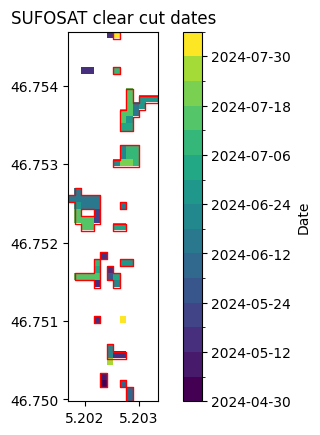

concave_hull_score = 0.20872613687723868
ID = 48730
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.28612423953662&lng=-0.6984776867996516
https://www.google.com/maps?q=44.28612423953662,-0.6984776867996516
0.65 hectares clear cut


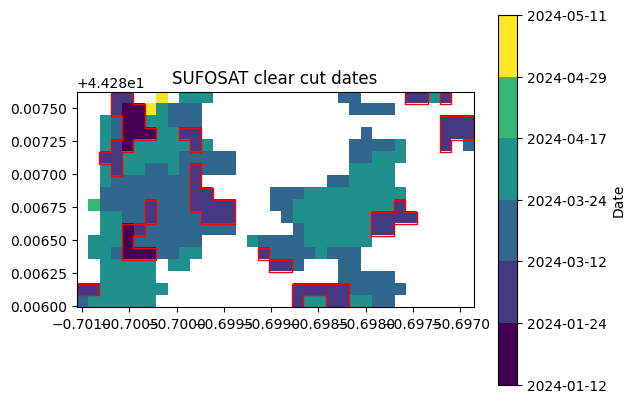

concave_hull_score = 0.2919095961768542
ID = 43
https://browser.dataspace.copernicus.eu/?zoom=17&lat=42.051850081918516&lng=9.446990173187118
https://www.google.com/maps?q=42.051850081918516,9.446990173187118
2.30 hectares clear cut


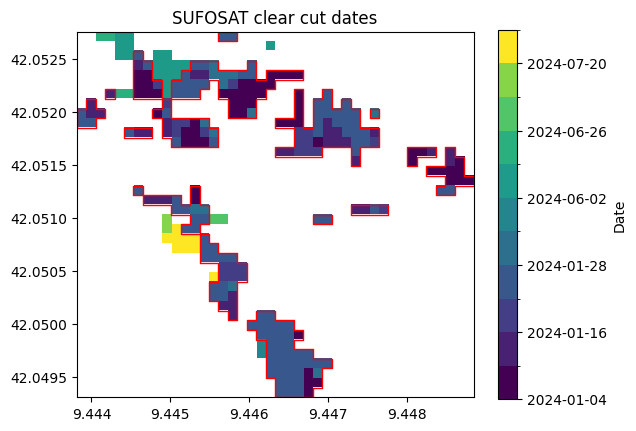

concave_hull_score = 0.2969392278984742
ID = 3486
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.12447776973964&lng=4.397994782110235
https://www.google.com/maps?q=44.12447776973964,4.397994782110235
15.01 hectares clear cut


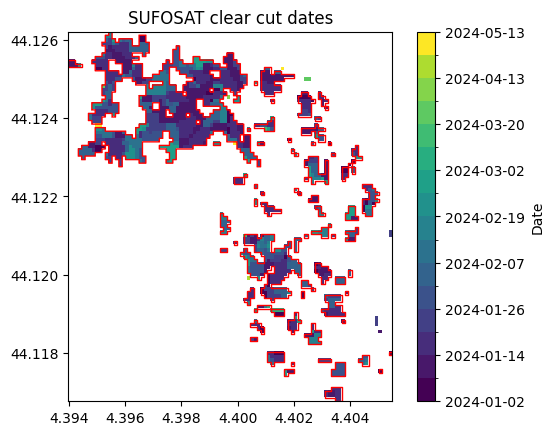

concave_hull_score = 0.3428618110614555
ID = 33427
https://browser.dataspace.copernicus.eu/?zoom=17&lat=45.92896355515104&lng=1.4653260987469516
https://www.google.com/maps?q=45.92896355515104,1.4653260987469516
1.07 hectares clear cut


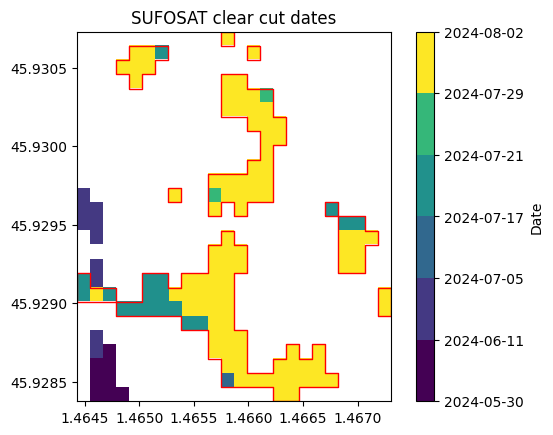

concave_hull_score = 0.35131778014002635
ID = 39832
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.22222698091852&lng=0.165940824611235
https://www.google.com/maps?q=44.22222698091852,0.165940824611235
1.22 hectares clear cut


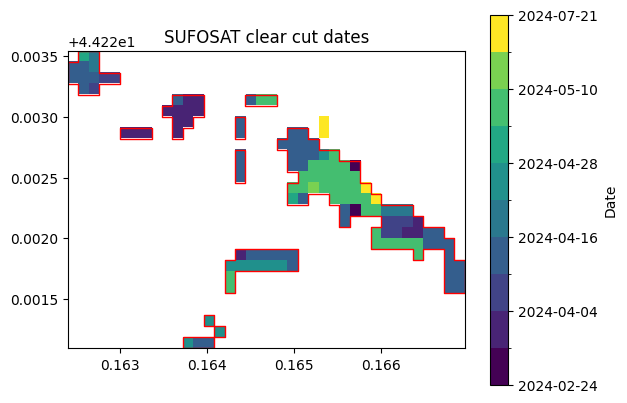

concave_hull_score = 0.36236414378178605
ID = 30021
https://browser.dataspace.copernicus.eu/?zoom=17&lat=45.168268952498636&lng=0.030643142212623514
https://www.google.com/maps?q=45.168268952498636,0.030643142212623514
1.22 hectares clear cut


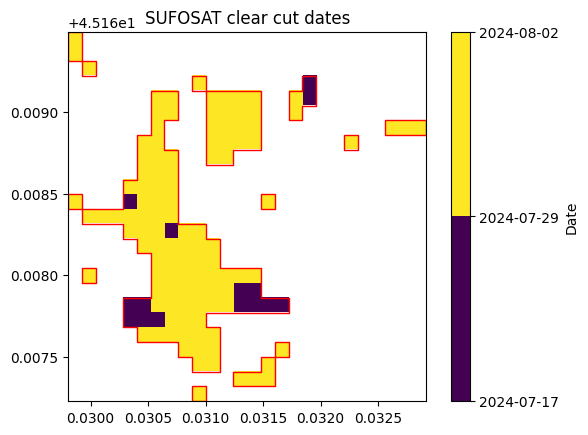

concave_hull_score = 0.3692351631518532
ID = 30036
https://browser.dataspace.copernicus.eu/?zoom=17&lat=45.1692659314875&lng=0.041373441334211454
https://www.google.com/maps?q=45.1692659314875,0.041373441334211454
0.91 hectares clear cut


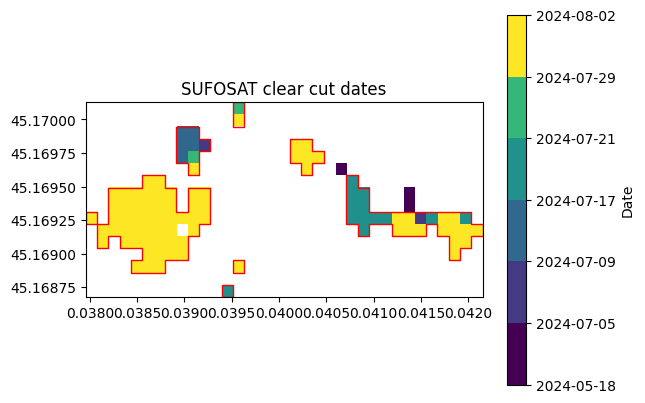

concave_hull_score = 0.4033483628532262
ID = 18107
https://browser.dataspace.copernicus.eu/?zoom=17&lat=46.91705989350227&lng=5.341182081525731
https://www.google.com/maps?q=46.91705989350227,5.341182081525731
1.77 hectares clear cut


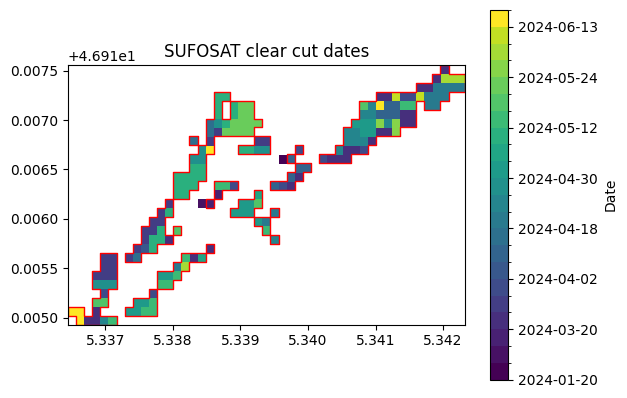

concave_hull_score = 0.4081651627131647
ID = 28234
https://browser.dataspace.copernicus.eu/?zoom=17&lat=45.943601012799604&lng=-0.7270718358637828
https://www.google.com/maps?q=45.943601012799604,-0.7270718358637828
0.84 hectares clear cut


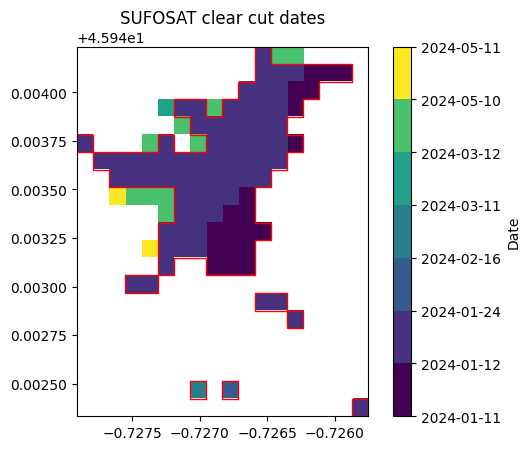

In [31]:
sparse_clear_cuts = gdf_group[gdf_group["concave_hull_score"] < MAGIC_NUMBER].sample(
    10, random_state=666
)
centroids = sparse_clear_cuts.to_crs(epsg=4326).representative_point()
for clear_cut_id in sparse_clear_cuts.sort_values("concave_hull_score").index:
    point = centroids.loc[clear_cut_id]
    print(
        "concave_hull_score =",
        sparse_clear_cuts.loc[clear_cut_id, "concave_hull_score"],
    )
    plot_example(sparse_clear_cuts, point.x, point.y)

In [32]:
# Filter out clear cuts that are too complex, and get rid of the score since it won't be useful later
gdf_group = gdf_group[gdf_group["concave_hull_score"] >= MAGIC_NUMBER].drop(
    columns="concave_hull_score"
)
gdf_group

,geometry,date_min,date_max,days_delta,clear_cut_group_size,area_ha
clear_cut_group,,,,,,
0,"POLYGON ((1242170.295 6021778.341, 1242150.15 ...",2024-04-21,2024-07-08,78,12,0.500123
1,"MULTIPOLYGON (((1233121.944 6028390.495, 12331...",2024-03-04,2024-04-21,48,19,1.386440
17,"POLYGON ((1198216.849 6067996.198, 1198216.087...",2024-06-20,2024-07-14,24,7,0.617602
20,"MULTIPOLYGON (((1163543.691 6133084.278, 11635...",2024-04-08,2024-07-25,108,51,2.102984
21,"POLYGON ((1188128.497 6151090.369, 1188128.497...",2024-05-26,2024-07-14,49,6,0.509373
...,...,...,...,...,...,...
51440,"POLYGON ((339052.06 6283945.469, 339032.711 62...",2024-07-15,2024-08-02,18,6,0.702793
51445,"MULTIPOLYGON (((340298.087 6286246.005, 340298...",2024-04-04,2024-06-21,78,39,3.122274
51449,"POLYGON ((340233.26 6285957.077, 340213.917 62...",2024-04-10,2024-05-10,30,10,0.829407


In [33]:
# Let's sort the clear cuts by their area
gdf_group = gdf_group.sort_values("area_ha")
gdf_group

,geometry,date_min,date_max,days_delta,clear_cut_group_size,area_ha
clear_cut_group,,,,,,
9966,"POLYGON ((985577.156 6371971.294, 985567.615 6...",2024-04-25,2024-07-02,68,9,0.500036
28331,"POLYGON ((376887.955 6490085.447, 376878.593 6...",2024-03-24,2024-06-04,72,10,0.500084
18212,"POLYGON ((910854.191 6599603.776, 910853.841 6...",2024-04-25,2024-06-24,60,13,0.500091
0,"POLYGON ((1242170.295 6021778.341, 1242150.15 ...",2024-04-21,2024-07-08,78,12,0.500123
43156,"POLYGON ((397948.518 6371582.432, 397948.518 6...",2024-06-20,2024-08-03,44,11,0.500130
...,...,...,...,...,...,...
48083,"MULTIPOLYGON (((375259.394 6342365.243, 375249...",2024-04-22,2024-08-02,102,408,28.212858
45978,"POLYGON ((383863.067 6413192.661, 383853.589 6...",2024-03-24,2024-08-03,132,382,30.446350
46950,"MULTIPOLYGON (((368631.052 6396178.685, 368629...",2024-01-12,2024-08-03,204,493,35.142598


At the end, we have about 150 clear cuts with an area greater than 10 hectares!


In [34]:
gdf_group[gdf_group["area_ha"] >= 10]

,geometry,date_min,date_max,days_delta,clear_cut_group_size,area_ha
clear_cut_group,,,,,,
40249,"POLYGON ((471543.827 6338974.48, 471543.826 63...",2024-02-05,2024-08-03,180,121,10.012494
40063,"POLYGON ((463214.121 6341961.718, 463185.363 6...",2024-06-28,2024-08-03,36,28,10.027192
29197,"MULTIPOLYGON (((429484.301 6470879.583, 429484...",2024-03-23,2024-08-03,133,116,10.028782
39798,"POLYGON ((468419.038 6351945.798, 468409.467 6...",2024-03-11,2024-08-02,144,140,10.039365
49929,"POLYGON ((358323.737 6305044.626, 358323.737 6...",2024-04-10,2024-08-02,114,114,10.066459
...,...,...,...,...,...,...
48083,"MULTIPOLYGON (((375259.394 6342365.243, 375249...",2024-04-22,2024-08-02,102,408,28.212858
45978,"POLYGON ((383863.067 6413192.661, 383853.589 6...",2024-03-24,2024-08-03,132,382,30.446350
46950,"MULTIPOLYGON (((368631.052 6396178.685, 368629...",2024-01-12,2024-08-03,204,493,35.142598


## Let's plot a few examples of the final clear cuts!


ID = 21484
https://browser.dataspace.copernicus.eu/?zoom=17&lat=47.39719568037982&lng=-0.17994647155340465
https://www.google.com/maps?q=47.39719568037982,-0.17994647155340465
0.93 hectares clear cut


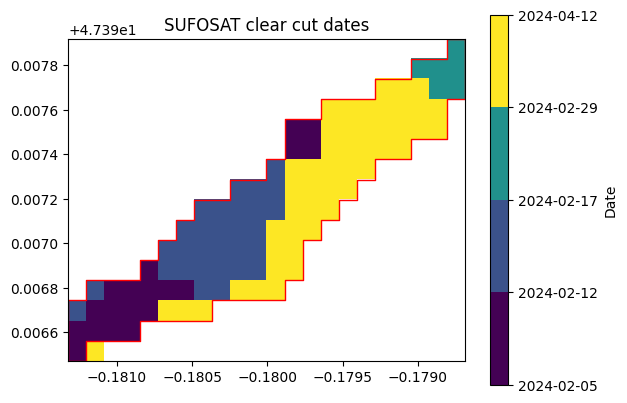

ID = 3623
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.22385840030243&lng=4.790639806300347
https://www.google.com/maps?q=44.22385840030243,4.790639806300347
5.05 hectares clear cut


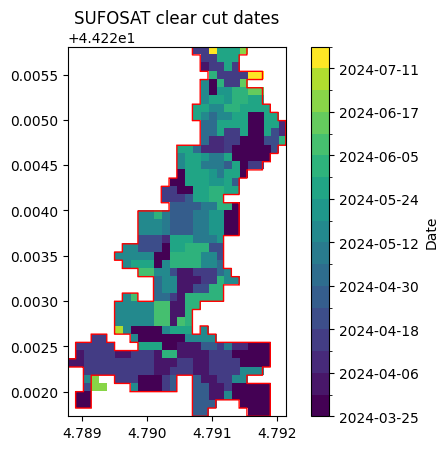

ID = 1733
https://browser.dataspace.copernicus.eu/?zoom=17&lat=43.620097278039346&lng=2.4133090625911073
https://www.google.com/maps?q=43.620097278039346,2.4133090625911073
4.90 hectares clear cut


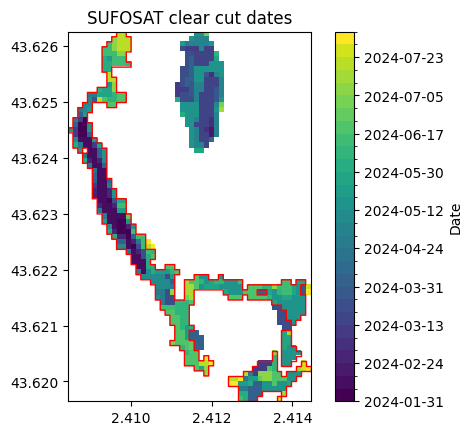

ID = 21198
https://browser.dataspace.copernicus.eu/?zoom=17&lat=47.25539814642903&lng=-0.8229251784226564
https://www.google.com/maps?q=47.25539814642903,-0.8229251784226564
0.58 hectares clear cut


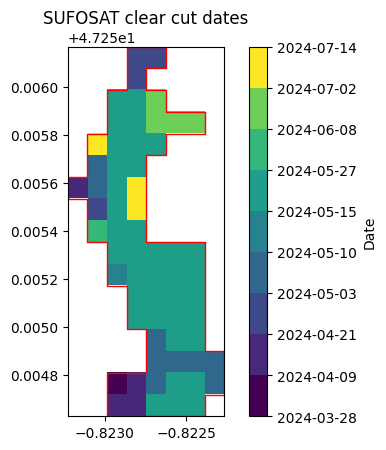

ID = 10857
https://browser.dataspace.copernicus.eu/?zoom=17&lat=45.17787619995863&lng=7.805314351201499
https://www.google.com/maps?q=45.17787619995863,7.805314351201499
0.88 hectares clear cut


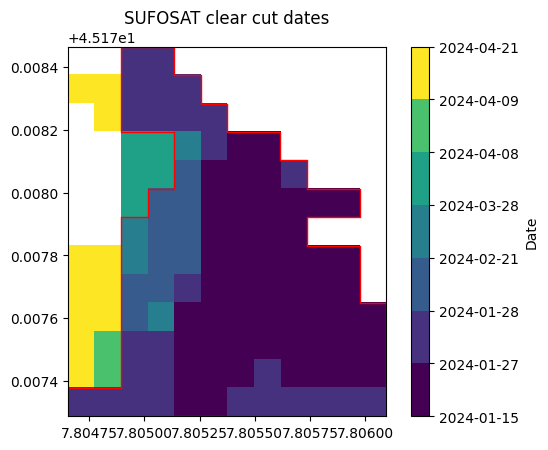

ID = 22193
https://browser.dataspace.copernicus.eu/?zoom=17&lat=47.34834373347803&lng=-0.03511740612201415
https://www.google.com/maps?q=47.34834373347803,-0.03511740612201415
0.81 hectares clear cut


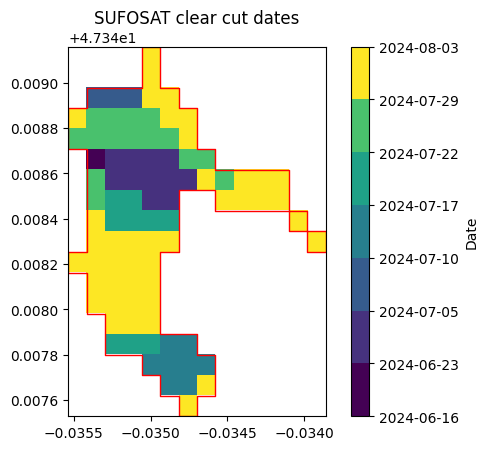

ID = 28027
https://browser.dataspace.copernicus.eu/?zoom=17&lat=47.190322639598904&lng=-1.6667223328058427
https://www.google.com/maps?q=47.190322639598904,-1.6667223328058427
1.86 hectares clear cut


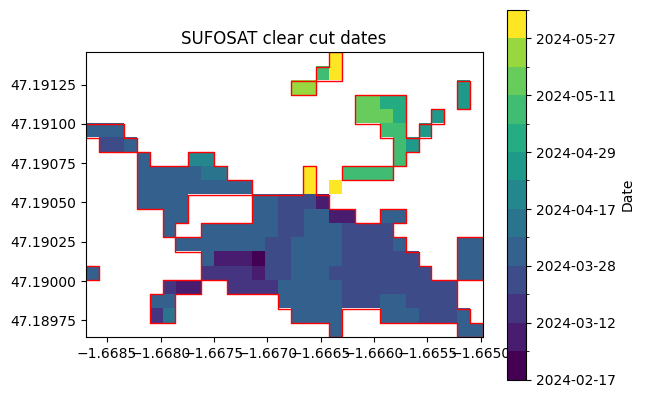

ID = 48831
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.257982255663535&lng=-0.520558536854825
https://www.google.com/maps?q=44.257982255663535,-0.520558536854825
1.85 hectares clear cut


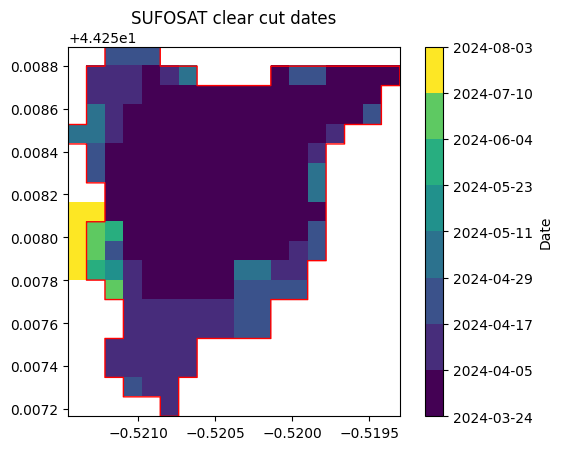

ID = 23026
https://browser.dataspace.copernicus.eu/?zoom=17&lat=47.807905509338966&lng=-0.13097074868088826
https://www.google.com/maps?q=47.807905509338966,-0.13097074868088826
0.63 hectares clear cut


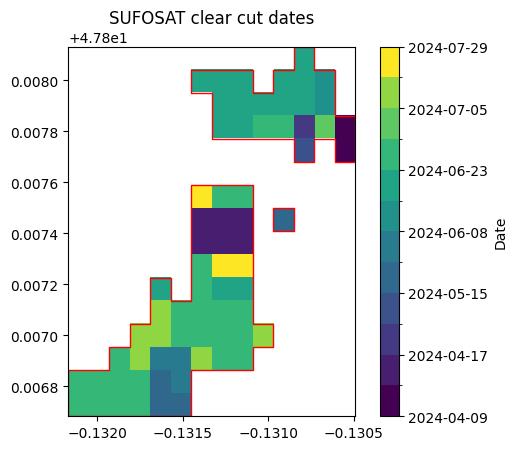

ID = 7618
https://browser.dataspace.copernicus.eu/?zoom=17&lat=46.135927230863764&lng=4.419875000974837
https://www.google.com/maps?q=46.135927230863764,4.419875000974837
0.61 hectares clear cut


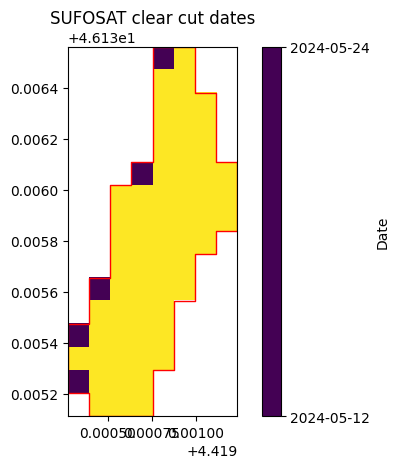

In [35]:
centroids = gdf_group.to_crs(epsg=4326).representative_point()
for clear_cut_id in gdf_group.sample(10, random_state=666).index:
    point = centroids.loc[clear_cut_id]
    plot_example(gdf_group, point.x, point.y)

## LGTM! Let's upload the result to S3


In [36]:
# Save the result to disk
# index=False because we don't need to keep the group id
gdf_group.to_file(OUTPUT_LAYER, index=False)

In [37]:
# Upload to s3
!aws s3 cp ../data/sufosat/sufosat_clear_cuts_2024.fgb s3://brigade-coupe-rase-s3/analytics/data/sufosat/sufosat_clear_cuts_2024.fgb --profile d4g-s13-brigade-coupes-rases

upload: ../data/sufosat/sufosat_clear_cuts_2024.fgb to s3://brigade-coupe-rase-s3/analytics/data/sufosat/sufosat_clear_cuts_2024.fgb


In [38]:
!aws s3 ls s3://brigade-coupe-rase-s3/ --recursive --profile d4g-s13-brigade-coupes-rases

2025-02-18 21:53:57   32993275 analytics/data/ign/bdalti25/slope_gte_30.tif
2025-02-21 13:26:51  120737768 analytics/data/sufosat/sufosat_clear_cuts_2024.fgb
